In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm 
import json
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.xmargin'] = 0#余白設定
mpl.rcParams['axes.ymargin'] = 0.05#デフォルト

In [3]:
folder_path = r'D:\experiment_data\20221024電気生理'
data_file_path = '1_1-32kHz_40trial_FP.mat'
csv_file_path = '1_tone.csv'
data_path = folder_path + str('/') + data_file_path
csv_path = folder_path + str('/') + csv_file_path
pre = 0.1 #刺激前の表示時間
post = 0.3 #刺激後の表示時間
ch = 12

In [4]:
def td_array(dual_array):
    #2次元配列のままだと気持ち悪いので１次元に直す
    array = []
    for i in range(len(dual_array)):
        array.append(dual_array[i][0])
    np_array = np.array(array)
    return(np_array)

In [5]:
Data = scipy.io.loadmat(data_path)
Event_stamp_raw = td_array(Data['EVT02'])

In [6]:
def sec_to_num(sec):
    ts_step = Data['FP01_ts_step'][0][0]
    return int(sec/ts_step)
sec_to_num(7.34745)

7347

In [7]:
def str_fp(num):
    if(num < 10):
        str_s = 'FP0' + str(num)
    else:
        str_s = 'FP' + str(num)
    return str_s

In [8]:
def num_to_sec(num):
    ts_step = Data['FP01_ts_step'][0][0]
    return float(num*ts_step)
num_to_sec(7347)

7.347

In [9]:
def csv_df(csv_path):
    #使わない、確認用
    df = pd.read_csv(csv_path)
    return df
csv_df = csv_df(csv_path)
print(csv_df)

        db     frequency  duration  trial      state
0     40.0   6168.843302      0.03    6.0  toneburst
1     80.0   1000.000000      0.03   22.0  toneburst
2     30.0   6727.171322      0.03   22.0  toneburst
3     50.0   8000.000000      0.03    8.0  toneburst
4     70.0   4362.030931      0.03    1.0  toneburst
...    ...           ...       ...    ...        ...
9835  40.0  13454.342640      0.03   24.0  toneburst
9836  40.0   1542.210825      0.03    4.0  toneburst
9837  40.0  29344.129380      0.03   25.0  toneburst
9838  80.0   8724.061861      0.03   38.0  toneburst
9839  30.0   5656.854249      0.03   14.0  toneburst

[9840 rows x 5 columns]


In [10]:
def csv_event_tone(csv_path,db,frequency):
    #csvを読み込んで音圧と周波数が何番目かを出力する
    csv_df = pd.read_csv(csv_path)
    db_df = csv_df[csv_df.db == db]
    specified_df =db_df[db_df.frequency == frequency]
    #print(specified_df)
    specified_num_list = specified_df.index.values + 1 #dfのindexは0スタート,stampは1スタートなので調整
    return specified_num_list
specified_num_list = csv_event_tone(csv_path,40,6168.843302)
print(specified_num_list)

[   1   55   58  480  582  764  886  918 1183 1212 1275 2090 2148 2697
 2830 3036 3116 3198 3250 3741 3747 3869 4515 4813 5591 5782 6143 6195
 6304 6748 6867 7106 7185 7567 7760 8332 8425 8761 9197 9813]


In [11]:
def one_wave_tone(ch,db,frequency,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_tone(csv_path,db,frequency)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
    return one_wave_np,sec_axis
        
one_wave_np,sec_axis = one_wave_tone(14,70,8000,20,csv_path)

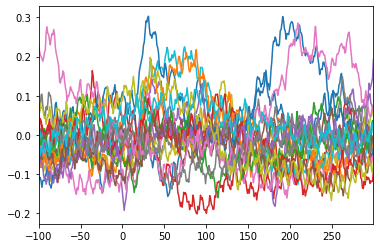

In [12]:
def one_wave_plot_tone(ch,db,frequency,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_tone(csv_path,db,frequency)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        plt.plot(sec_axis,one_wave_data)#デバッグ
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
one_wave_plot_tone(14,70,8000,20,csv_path)

In [13]:
def multi_wave_tone(ch,db,frequency,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_tone(ch,db,frequency,trial_num,csv_path)
    if(len(one_wave_np) < trial_num):
        print("試行回数が指定より不足しています")#エラー文
    else:
        weight_average = one_wave_np[0]
        for i in range(int(trial_num)):
            if(i == 0):pass#初期化対策
            else:weight_average = weight_average + one_wave_np[i]
            
        weight_average = weight_average /  int(trial_num)
        return weight_average,sec_axis
weight_average,sec_axis = multi_wave_tone(14,70,8000,20,csv_path)

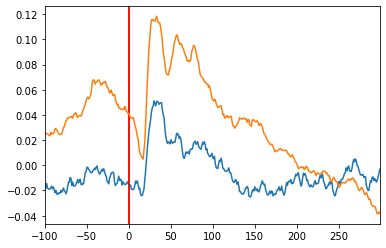

In [14]:
def multi_wave_plot_tone(ch,db,frequency,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_tone(ch,db,frequency,trial_num,csv_path)
    if(len(one_wave_np) < trial_num):
        print("試行回数が指定より不足しています")#エラー文
    else:
        weight_average = one_wave_np[0]
        for i in range(int(trial_num)):
            if(i == 0):pass#初期化対策
            else:weight_average = weight_average + one_wave_np[i]
            
        weight_average = weight_average /  int(trial_num)
        plt.axvline(x=0, color='r')
        plt.plot(sec_axis,weight_average)
        return weight_average,sec_axis
weight_average,sec_axis= multi_wave_plot_tone(14,70,8000,20,csv_path)
weight_average,sec_axis= multi_wave_plot_tone(10,50,32000,20,csv_path)

In [15]:
#ここから求愛音
#求愛音の冠詞はcourtshipと置く

In [16]:
folder_path = r'D:\experiment_data\20221024電気生理'
data_file_path = '2_kyuuai_FP.mat'
csv_file_path = '2_kyuuai.csv'
data_path = folder_path + str('/') + data_file_path
csv_path = folder_path + str('/') + csv_file_path
pre = 0.3 #刺激前の表示時間
post = 0.7 #刺激後の表示時間
ch = 12

In [25]:
def csv_event_courtship(csv_path,sound_name):
    #csvを読み込んで音圧と周波数が何番目かを出力する
    csv_df = pd.read_csv(csv_path)
    specified_num_list = []
    #specified_df_df = csv_df[csv_df.0 == sound_name]
    for i in range(len(csv_df)):
        if(csv_df["0"][i] == sound_name):
            specified_num_list.append(i+1)
    return specified_num_list
csv_event_courtship(csv_path,"upwardramp_98_5.6_0.2.npy")

[1, 200, 399, 598, 797, 996, 1195, 1394, 1593, 1792]

In [39]:
def one_wave_courtship(sound_name,ch,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_courtship(csv_path,sound_name)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
    return one_wave_np,sec_axis
        
one_wave_np,sec_axis = one_wave_courtship("upwardramp_98_5.6_0.2.npy",10,10,csv_path)

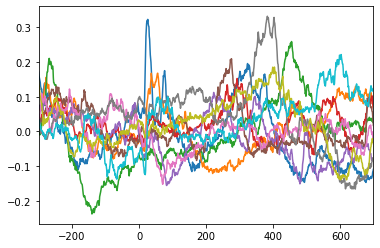

In [40]:
def one_wave_plot_courtship(sound_name,ch,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_courtship(csv_path,sound_name)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        plt.plot(sec_axis,one_wave_data)
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
    return one_wave_np,sec_axis
        
one_wave_np,sec_axis_plot = one_wave_plot_courtship("upwardramp_98_5.6_0.2.npy",10,10,csv_path)

In [54]:
def multi_wave_courtship(ch,sound_name,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_courtship(sound_name,ch,trial_num,csv_path)
    
    weight_average = one_wave_np[0]
    for i in range(int(trial_num)):
        if(i == 0):pass#初期化対策
        else:weight_average = weight_average + one_wave_np[i]

    weight_average = weight_average /  int(trial_num)
    return weight_average,sec_axis
weight_average,sec_axis = multi_wave_courtship(10,"upwardramp_98_5.6_0.2.npy",10,csv_path)

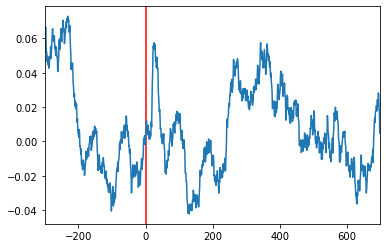

In [57]:
def multi_wave_plot_courtship(ch,sound_name,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_courtship(sound_name,ch,trial_num,csv_path)
    
    weight_average = one_wave_np[0]
    for i in range(int(trial_num)):
        if(i == 0):pass#初期化対策
        else:weight_average = weight_average + one_wave_np[i]

    weight_average = weight_average /  int(trial_num)
    plt.axvline(x=0, color='r')
    plt.plot(sec_axis,weight_average)
    return weight_average,sec_axis
weight_average,sec_axis = multi_wave_plot_courtship(14,"upwardramp_98_5.6_0.2.npy",10,csv_path)